# **Recurrent Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [6]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [7]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [8]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [9]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [10]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [11]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **RNN Model**

In [69]:
def build_model(audio_features,
                learning_rate=0.00005,
                gru_units=256,
                hidden_layers=[128, 64],
                dropout_rate=0.4):

    tf.keras.backend.clear_session()

    # Input layer
    inputs = tf.keras.layers.Input(shape=(audio_features.shape[1], audio_features.shape[2]), name='Audio_Features')

    # First GRU layer with return_sequences=True to stack another GRU layer
    x = tf.keras.layers.GRU(gru_units, return_sequences=True)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    # Second GRU layer without return_sequences, leading to the final fully connected layers
    x = tf.keras.layers.GRU(gru_units//2, kernel_regularizer=tf.keras.regularizers.l2(0.15))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Fully connected layers
    for units in hidden_layers:
        x = tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=20, activation='softmax')(x)

    # Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    print(model.summary())

    return model


In [57]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_GRU_100epochs.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [15]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [16]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs and Chroma

In [58]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc'], train_features['chroma']), axis=1)

print(training_features.shape)

(5278, 160, 259)


In [59]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc'], val_features['chroma']), axis=1)

print(validation_features.shape)

(1350, 160, 259)


In [70]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 160, 259)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 160, 256)            │         397,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 573,652 (2.19 MB)

 Trainable params: 572,500 (2.18 MB)

 Non-trainable params: 1,152 (4.50 KB)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.0680 - loss: 89.2271 - val_accuracy: 0.0467 - val_loss: 80.1092
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1225 - loss: 77.4423 - val_accuracy: 0.0800 - val_loss: 69.8108
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1688 - loss: 67.3374 - val_accuracy: 0.2089 - val_loss: 60.6114
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2027 - loss: 58.6014 - val_accuracy: 0.2296 - val_loss: 52.8239
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2185 - loss: 51.1131 - val_accuracy: 0.2763 - val_loss: 45.9416
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2565 - loss: 44.5272 - val_accuracy: 0.3252 - val_loss: 40.0715
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3010 - loss: 38.8275 - val_accuracy: 0.3111 - val_loss: 35.0354
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.308

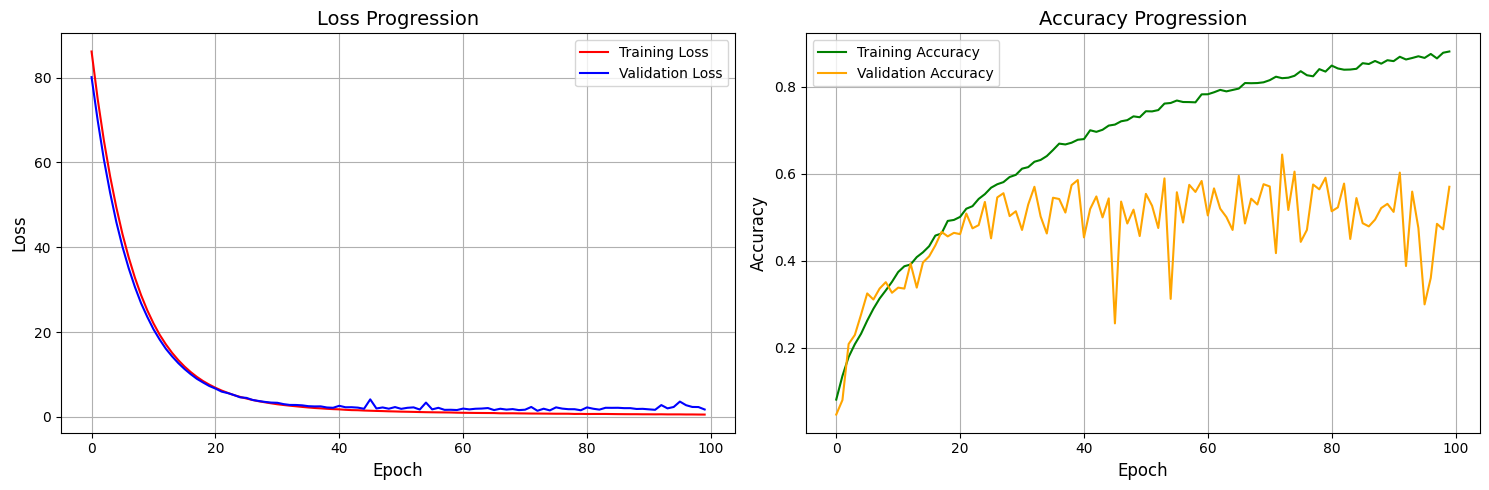

In [71]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [72]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7884 - loss: 0.7697
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5769 - loss: 1.7117


In [73]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.44      0.95      0.60       114
           1       0.44      0.36      0.40       141
           2       0.74      0.70      0.72       271
           3       0.93      0.30      0.45        90
           4       0.20      0.50      0.29        18
           5       0.00      0.00      0.00        15
           6       0.36      0.22      0.27        23
           7       0.81      0.98      0.89        44
           8       0.36      0.42      0.39        50
           9       0.92      0.49      0.64        49
          10       0.66      0.77      0.71        48
          11       0.40      0.59      0.48        46
          12       0.77      0.93      0.84        54
          13       0.33      0.02      0.04        48
          14       0.44      0.66      0.53        38
          15       0.61      0.30      0.40       117
          16       0.69      0.91      0.79   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
